In [1]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import numpy as np
import scipy as sc
import time as tm
import pickle
import sympy.physics.mechanics as me
import sys
sys.path.insert(0, "..")
from importlib import reload

In [2]:
import equations as eq
reload (eq);
model_struct = sc.io.loadmat('../das3_quat_abd.mat')
data_struct = sc.io.loadmat('../data_model.mat')
initPos = 'InitPosOptQuat'
start = tm.time()
MM,FO,TE,q,w,u0,fr,frstar,kinematical,xdot,holonomic,activations = eq.create_eoms_u0state(model_struct,data_struct,initPos,derive = 'numeric')
time_to_create = tm.time() - start
print(time_to_create)

367.23846769332886


In [17]:
import equations as eq
reload (eq);
# dict_vals,symlist, value_list = eq.create_parameters_dict(data_struct, initPos)
x0 = data_struct['params'][initPos][0,0]['initCondQuat'].item()
x0t = list(x0.T[0])

In [18]:
eoms_implicit = sp.Matrix(kinematical).col_join(fr+frstar+TE).col_join(holonomic)

In [19]:
import trajectory_lib as tr
reload (tr);
num_nodes = 101
file = '../Motion/abduciton/abd_struct.mat'
traj, interval_value, time, _ = tr.exp_trajectory_quat(file,num_nodes)

state_symbols = tuple(q+w+u0)
num_states = len(state_symbols)
specified_symbols = tuple(activations)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

In [20]:
traj_w = 250
vel_w = 10
act_w = 20


def obj(free):
    min_traj = traj_w * interval_value * np.sum((traj - free[:13*num_nodes])**2)
    min_vel = vel_w * interval_value * np.sum((free[13*num_nodes:num_states*num_nodes])**2)
    min_torque = act_w * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return min_traj + min_torque + min_vel

def obj_grad(free):
    grad = np.zeros_like(free)
    grad[:13*num_nodes] = traj_w * 2.0 * interval_value * (free[:13*num_nodes] - traj)
    grad[13*num_nodes:num_states*num_nodes] = vel_w * 2 * interval_value * free[13*num_nodes:num_states*num_nodes]
    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = act_w * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad

In [21]:
instance_constraints = []
# for i in range(13):
instance_constraints.append(state_symbols[12].func(0.0)-x0t[12]) 
    
bounds1 = (0.0,1.0)
bounds = (bounds1,)*len(activations)
bndrs = dict(zip(activations,bounds))

In [22]:
start = tm.time()
prob = Problem(obj, obj_grad, eoms_implicit, state_symbols,
               num_nodes, interval_value,
               known_parameter_map={},
               instance_constraints=instance_constraints,
               bounds=bndrs,
               integration_method='midpoint')


time_to_create = tm.time() - start
print(time_to_create)



1385.7443811893463


In [23]:

prob.add_option('max_iter',10000)
prob.add_option('limited_memory_max_history', 40)

In [24]:
initial_guess = np.zeros(prob.num_free)
initial_guess[:13*num_nodes] = traj

In [25]:
solution, info = prob.solve(initial_guess)
print(info['status_msg'])
print(info['obj_val'])

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:   790401
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    15352
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    12726
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2601
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.8177924e-01 2.78e+02 1.23e-02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [26]:
print(info['status_msg'])
print(info['obj_val'])

b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
12.779159759147866


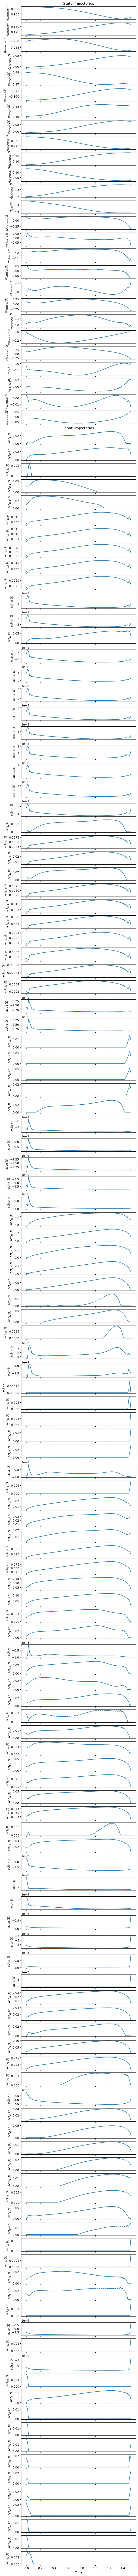

In [29]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(int(num_states+num_inputs), 1, sharex=True,
                         figsize=(6.4, 0.8*(num_states+num_inputs)),
                         layout='compressed')
prob.plot_trajectories(solution, axes=axes)

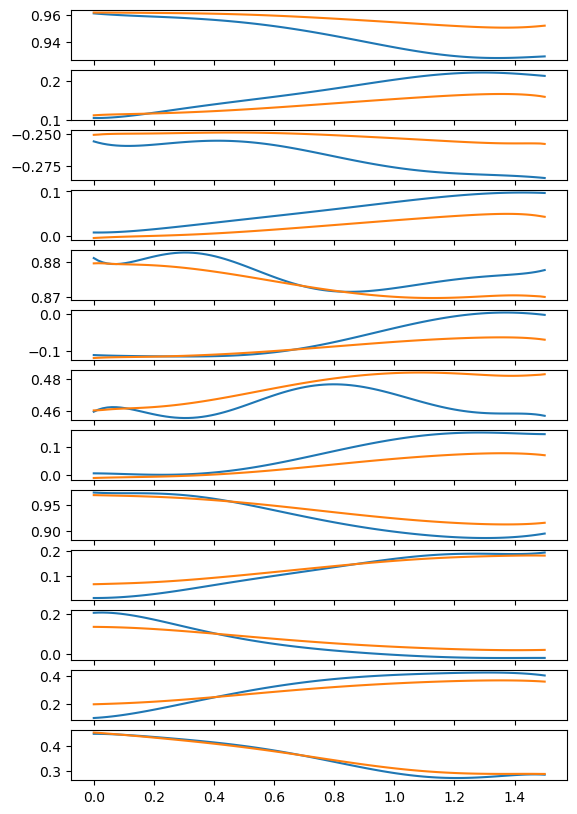

In [28]:
fig, axs = plt.subplots(13)
for j in range(13):
    axs[j].plot(time,traj[j*num_nodes:(j+1)*num_nodes])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(10)